In [ ]:
#!{sys.executable} -m pip install mplsoccer

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from statsbombpy import sb
import mplsoccer

# LDA / QDA / RF
from tqdm import tqdm
import shap

# NN model 
import torch
import torch.nn as nn

C:\Users\curra\anaconda3\envs\sfml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sb.competitions().head(2)

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381


In [3]:
# Get competitions that have 360 data
competitions = sb.competitions()
competition_360 = competitions[~competitions["match_available_360"].isnull()]  # Keep only competitions where 360 data available

# Gather all matches from these filtered competitions
all_matches = []

for _, row in competition_360.iterrows():
    cd = row["competition_id"]
    sd = row["season_id"]
    matches = sb.matches(
        competition_id = cd,
        season_id = sd
    )
    
    # Keep only relevant columns and add some information about the competition, season to be able to separate if needed
    matches["competition_id"] = cd
    matches["season_id"] = sd
    matches["competition_name"] = row["competition_name"]
    matches["season_name"] = row["season_name"]
    all_matches.append(matches)

# Combine all into one DataFrame
all_matches_df = pd.concat(all_matches, ignore_index=True)

# Filter to matches that actually have 360 data - Extra check
matches_360 = all_matches_df[~all_matches_df["last_updated_360"].isnull()]

# Sample 100 random matches to be sure to have enough data
sampled_matches = matches_360.sample(n = 100, random_state=42)

# Get event data for each sampled match
event_data = []

for idx, row in sampled_matches.iterrows():
    match_id = row["match_id"]
    try:
        events = sb.events(match_id = match_id)
    except Exception as e:
        print(f"Error retrieving match {match_id}: {e}")
        continue
    
    events["match_id"] = match_id
    events["competition_name"] = row["competition_name"]
    events["season_name"] = row["season_name"]
    events["home_team"] = row["home_team"]
    events["away_team"] = row["away_team"]
    events["sample_index"] = idx  # track which sampled match

    event_data.append(events)

# Combine all events into one DataFrame
sampled_events_df = pd.concat(event_data, ignore_index = True)


C:\Users\curra\AppData\Local\Temp\ipykernel_16064\3800115585.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab20", len(competition_matches_sorted))


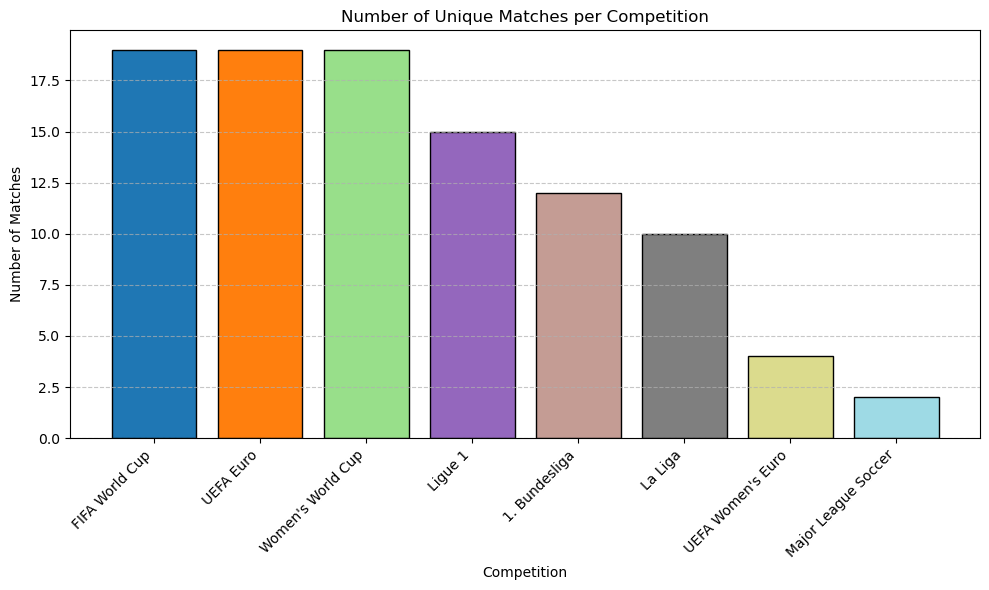

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Plot number of matches per competition
competition_matches = sampled_events_df.groupby("competition_name")["match_id"].nunique()
competition_matches_sorted = competition_matches.sort_values(ascending = False)

# Plot
colors = cm.get_cmap("tab20", len(competition_matches_sorted)) 
plt.figure(figsize=(10, 6))
bars = plt.bar(
    competition_matches_sorted.index,
    competition_matches_sorted.values,
    color=[colors(i) for i in range(len(competition_matches_sorted))],
    edgecolor='black'
)

plt.title("Number of Unique Matches per Competition")
plt.xlabel("Competition")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45, ha = "right")
plt.tight_layout()
plt.grid(axis = "y", linestyle = '--', alpha=0.7)
plt.show()


In [6]:
column_names = [
    "location",
    "pass_angle",
    "pass_body_part",
    "pass_end_location",
    "pass_height",
    "pass_length",
    "pass_outcome",
]

# Recover event that was a pass during the match and if a pass was successful put 1 otheriwse 0
passes_per_match_df = sampled_events_df[sampled_events_df["type"] == "Pass"][column_names]
passes_per_match_df['outcome'] = np.array(
    [1 if pd.isna(o) else 0 for o in passes_per_match_df["pass_outcome"].values]
).T
passes_per_match_df = passes_per_match_df.drop(columns = ["pass_outcome"])

# pass_body_part has still some null values but not too much. In ordor to keep column delete rows where this column has null values
passes_per_match_df = passes_per_match_df.dropna(subset = ["pass_body_part"])  

In [7]:
# Extract starting point of the ball and ending point of the ball
passes_per_match_df["x1"] = passes_per_match_df["location"].apply(lambda loc: loc[0])
passes_per_match_df["y1"] = passes_per_match_df["location"].apply(lambda loc: loc[1])
passes_per_match_df["x2"] = passes_per_match_df["pass_end_location"].apply(lambda loc: loc[0])
passes_per_match_df["y2"] = passes_per_match_df["pass_end_location"].apply(lambda loc: loc[1])
passes_per_match_df = passes_per_match_df.drop(columns = ["pass_end_location", "location"], axis = 1)
passes_per_match_df = pd.get_dummies(passes_per_match_df)  # Dummy variables created seperately because we have enough data

# Convert boolean columns to integers
for col in passes_per_match_df.columns:
    if passes_per_match_df[col].dtype == bool:
        passes_per_match_df[col] = passes_per_match_df[col].astype(int)

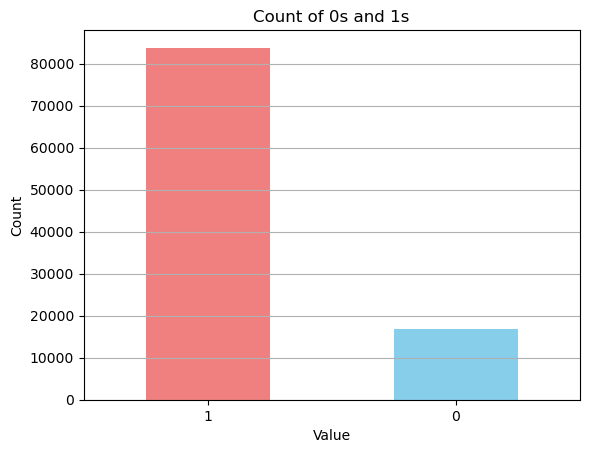

In [8]:
# Plot the outcome column to see if it is balanced or not.
passes_per_match_df["outcome"].value_counts().plot(kind = "bar", color = ["lightcoral", "skyblue"])
plt.title("Count of 0s and 1s")
plt.xlabel("Value")
plt.ylabel("Count")
plt.xticks(rotation = 0)
plt.grid(axis = "y")
plt.show()

## Model
- From the graph above we can see that the data is not balanced so we need to use stratified splitting of data to ensure that the data is balanced in both training and testing
- We create a MLP model with 2 hidden layers with 128 neurons. This should be a big enough model to get good results

In [9]:
# Standardize and split data in train and test
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

# Separate features and target
X = passes_per_match_df.drop(columns=["outcome"]).values
y = passes_per_match_df["outcome"].values

# Train test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index,], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape (n, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32)

In [12]:
# Work with gpu instead of cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Epoch 1/40 - Train Loss: 0.3024 - Test Loss: 0.2849
Epoch 2/40 - Train Loss: 0.2783 - Test Loss: 0.2785
Epoch 3/40 - Train Loss: 0.2746 - Test Loss: 0.2806
Epoch 4/40 - Train Loss: 0.2731 - Test Loss: 0.2789
Epoch 5/40 - Train Loss: 0.2720 - Test Loss: 0.2787
Early stopping at epoch 5. Best test loss: 0.2785


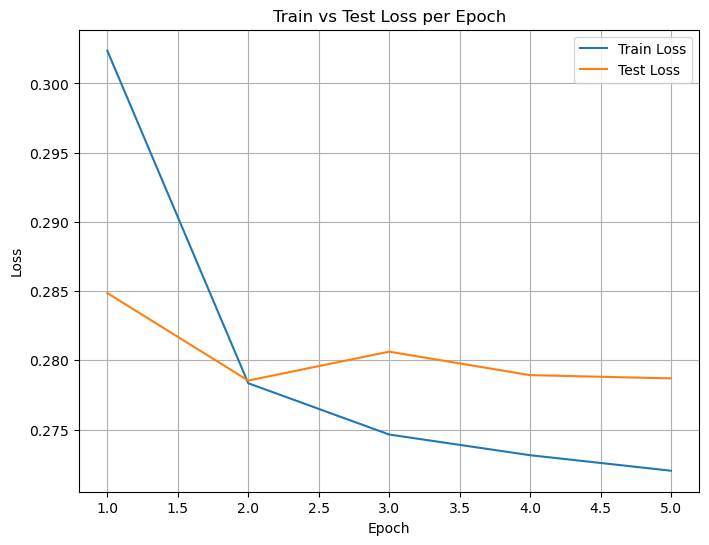

In [14]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # Input layer to Hidden layer 128 nodes
            nn.ReLU(),  # Relu activation function
            nn.Linear(128, 128),  # Hidden L1 to hidden L2 - 128 nodes
            nn.ReLU(),
            nn.Linear(128, 1),  # Hidden L2 to output L
            nn.Sigmoid()  # For binary classification to get probabilities of one or the other
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim = X_train.shape[1]).to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-4)

train_losses = []
test_losses = []

num_epochs = 40
patience = 3  # Early stopping - If test bce does not improve after 3 epochs stop
epochs_no_improve = 0  # Count number of epochs the model did not improve
best_test_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.float())  # ensure y_batch is float
        optimizer.zero_grad()  # Make sure grad is set to 0 after each epoch
        loss.backward()
        optimizer.step()
        
        # Normally for every batch_size you will have an averaged loss but if you want to compare the loss after each epoch
        # it is better to multiply the loss with the batch size and after each epoch take the mean epoch loss. Since batch sizes may differ
        # this will be less biased
        epoch_loss += loss.item() * X_batch.size(0)  

    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    # Evaluate test loss after each epoch
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.float())
            test_loss += loss.item() * X_batch.size(0)
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_epoch_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

    # Early stopping logic
    if avg_test_loss < best_test_loss - 1e-4:  # allow small improvement threshold
        best_test_loss = avg_test_loss
        best_model_state = model.state_dict()  # Keep model parameters saved
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best test loss: {best_test_loss:.4f}")
            break

# Load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Plot train vs test loss
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label = "Train Loss")
plt.plot(range(1, len(test_losses)+1), test_losses, label = "Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation
model.eval()
all_labels = []
all_preds = []
all_preds_prob = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred_prob = model(X_batch)
        all_preds_prob.extend(y_pred_prob.squeeze().tolist())
        preds = (y_pred_prob > 0.5).int()
        all_preds.extend(preds.squeeze().tolist())
        all_labels.extend(y_batch.int().squeeze().tolist())

Test Accuracy: 0.8850

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62      3362
           1       0.92      0.95      0.93     16764

    accuracy                           0.89     20126
   macro avg       0.80      0.76      0.78     20126
weighted avg       0.88      0.89      0.88     20126



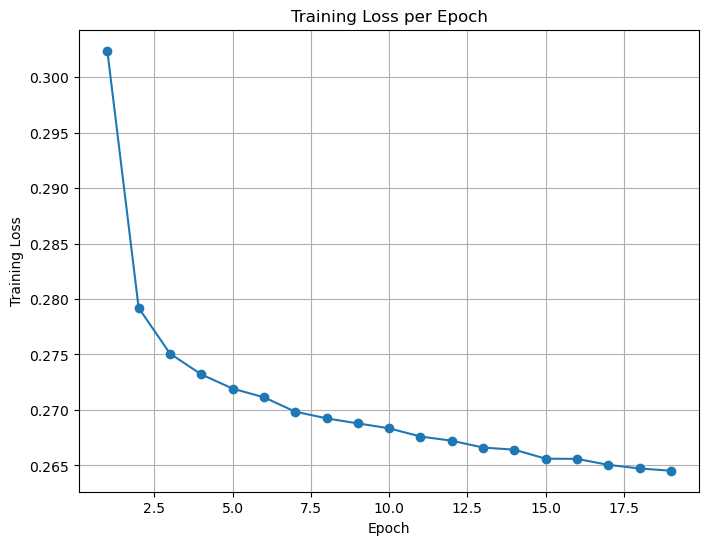

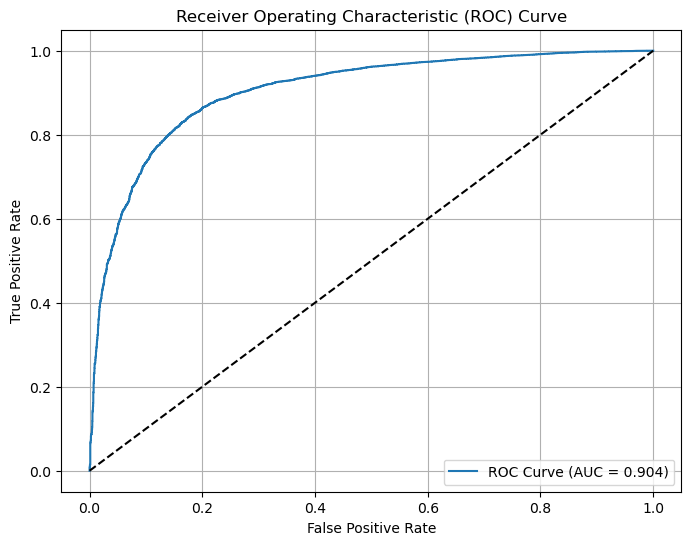

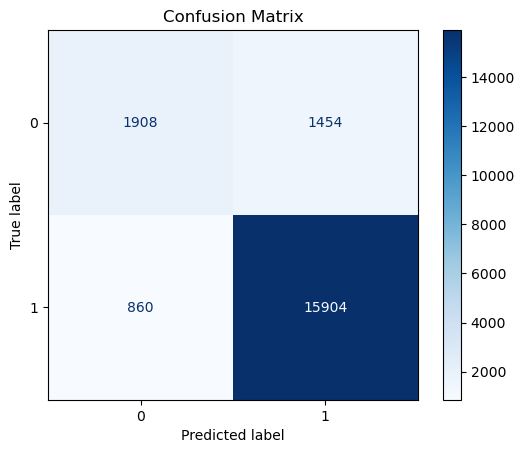

In [11]:
# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_preds_prob)
roc_auc = auc(fpr, tpr)


# Plot training loss curve
plt.figure(figsize = (8,6))
plt.plot(range(1, epoch + 2), train_losses, marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()